In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from langdetect import detect

In [2]:
from matplotlib import cm
colors = list(cm.get_cmap('tab20').colors)

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_43952/3467234849.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = list(cm.get_cmap('tab20').colors)


In [3]:
sdg_names = pd.read_excel("Digital Science SDG training set searches.xlsx")
sdg_names = sdg_names.drop([0,1,2], axis=0)
sdg_names = sdg_names.set_axis(["sdg", "sdg_name", "sdg_definition"],axis=1, copy=False)

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

embed_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(embed_url) # print ("module %s loaded" % module_url)

2023-03-24 18:59:56.913292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def get_text_df(file_name):
    text_df = pd.read_csv(file_name, sep = "\t", quotechar='"')
    col_names = text_df.columns.values[0].split('\t')
    text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
    text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
    text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
    text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
    text_df.reset_index(drop=True, inplace=True)
    return text_df

In [6]:
file_name = "/Users/yingli/Downloads/osdg-community-data-v2023-01-01.csv"
text_df = get_text_df(file_name)
text_df["embedding"] = list(embed(text_df.text))

2023-03-24 19:00:13.070625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


#### multiclass classifier by RidgeClassifier

              precision    recall  f1-score   support

           1     0.7346    0.7422    0.7384       481
           2     0.7572    0.8291    0.7915       316
           3     0.9084    0.9125    0.9104       674
           4     0.8598    0.9525    0.9038       863
           5     0.8723    0.9359    0.9030       920
           6     0.8478    0.8624    0.8550       465
           7     0.8171    0.8753    0.8452       730
           8     0.6942    0.4759    0.5647       353
           9     0.7320    0.6494    0.6882       328
          10     0.7006    0.4297    0.5327       256
          11     0.7747    0.7965    0.7855       462
          12     0.8841    0.5622    0.6873       217
          13     0.7473    0.7946    0.7702       443
          14     0.8849    0.8479    0.8660       263
          15     0.8605    0.8083    0.8336       313
          16     0.9013    0.9499    0.9249      1057

    accuracy                         0.8316      8141
   macro avg     0.8111   

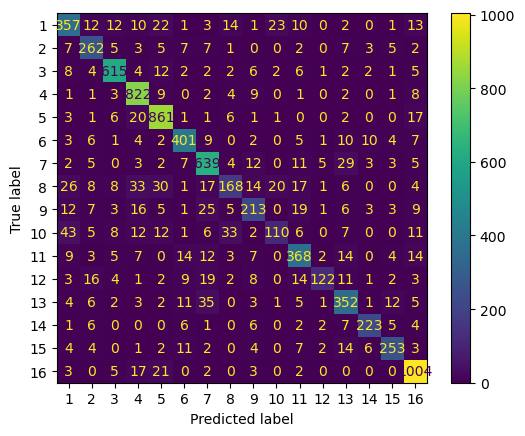

In [7]:
docs = text_df.embedding.tolist()
scaler = preprocessing.MinMaxScaler().fit(docs)
X = scaler.transform(docs)
y = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
ridge_clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
ridge_clf = ridge_clf.fit(X_train, y_train)
y_pred = ridge_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### multiclass classifier using One vs Rest (OvR) strategy

In [8]:
docs = text_df.embedding.tolist()
scaler = preprocessing.MinMaxScaler().fit(docs)
X = scaler.transform(docs)
y = text_df.sdg

label_binarizer = LabelBinarizer().fit(y)
y_onehot = label_binarizer.transform(y)
n_classes = len(label_binarizer.classes_)
class_names = [sdg_names[sdg_names["sdg"] == label_binarizer.classes_[i]].sdg_name.item() \
               for i in range(n_classes)]

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=.33, random_state=0)
ovr_mlp_clf = OneVsRestClassifier(MLPClassifier(random_state=0, max_iter=300)).fit(X_train,y_train)
y_score = ovr_mlp_clf.predict_proba(X_test)

* compute fpr, tpr, auc
* plot One vs Rest ROC curve for each class

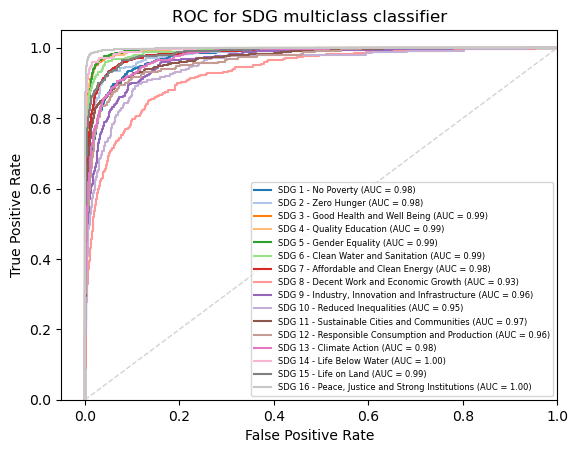

In [9]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_id in range(n_classes):
    fpr[class_id], tpr[class_id], _ = metrics.roc_curve(y_test[:, class_id], y_score[:, class_id]) # roc_curve works on binary
    roc_auc[class_id] = metrics.auc(fpr[class_id], tpr[class_id])

for class_id, color in zip(range(n_classes), colors):
    plt.plot(fpr[class_id], tpr[class_id], color=color, lw=1.5,alpha = 1, 
             label='SDG {0} - {1} (AUC = {2:0.2f})'
             ''.format(class_id+1, class_names[class_id], roc_auc[class_id]))
plt.plot([0, 1], [0, 1], '--', lw=1, color="lightgrey")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SDG multiclass classifier')
plt.legend(loc="lower right", fontsize=6)
plt.show()

In [10]:
docs = text_df.embedding.tolist()
scaler = preprocessing.MinMaxScaler().fit(docs)
X = scaler.transform(docs)
y = text_df.sdg

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

logit_clf = LogisticRegression(tol=1e-2, solver="liblinear")
logit_clf = logit_clf.fit(X_train, y_train)

# metrics.roc_auc_score work on binary and multiclass
y_score = logit_clf.predict_proba(X_test)
print(metrics.roc_auc_score(y_test,y_score, multi_class='ovr'))

0.9829967786981559


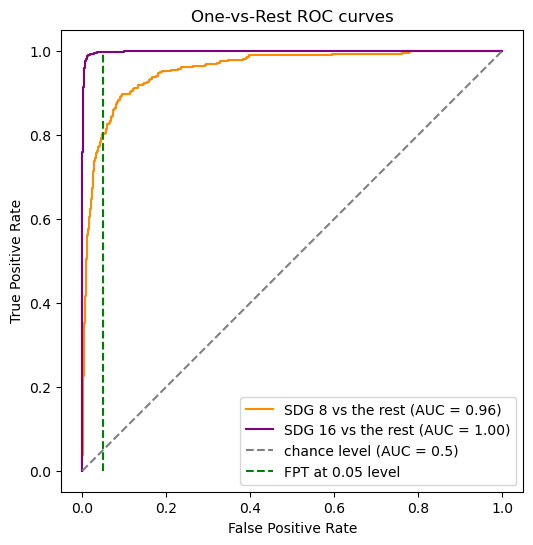

In [11]:
label_binarizer = LabelBinarizer().fit(y)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(figsize=(6,6))

class_of_interest = 8 # SDG 8
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"SDG {class_of_interest} vs the rest",
    color="darkorange",
    ax = ax,
)

class_of_interest = 16
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"SDG {class_of_interest} vs the rest",
    color="purple",
    ax = ax,
)

plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)", color = "grey")
plt.plot([0.05, 0.05], [0, 1], "--", label="FPT at 0.05 level", color = "green")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()

In [12]:
fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.99


In [13]:
n_classes = len(label_binarizer.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.98


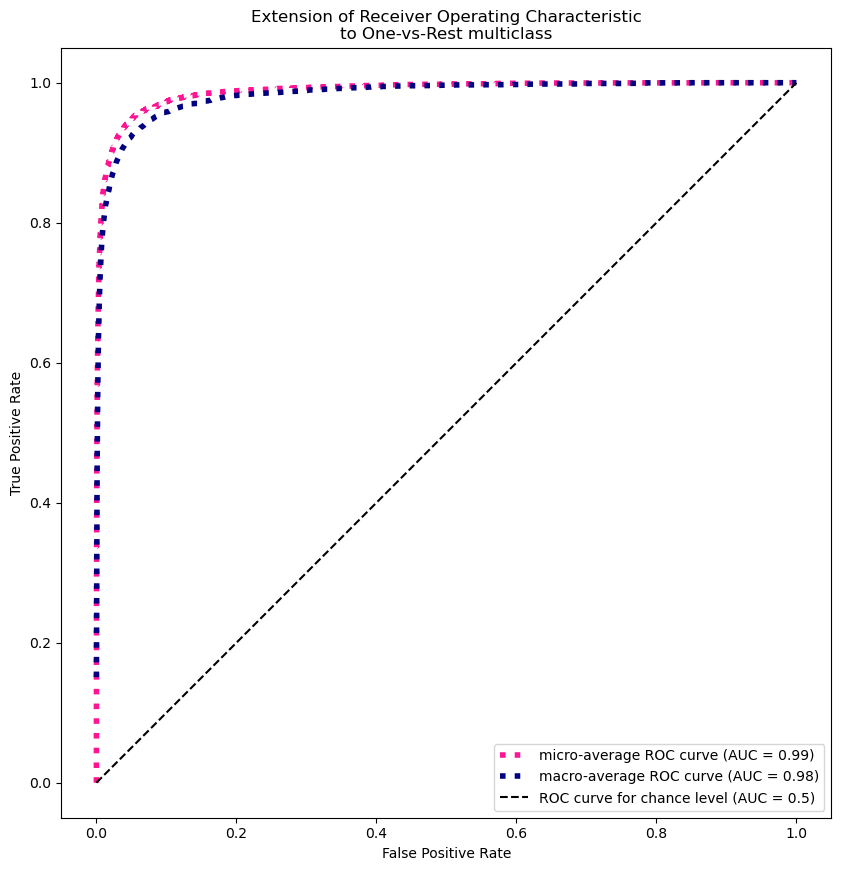

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

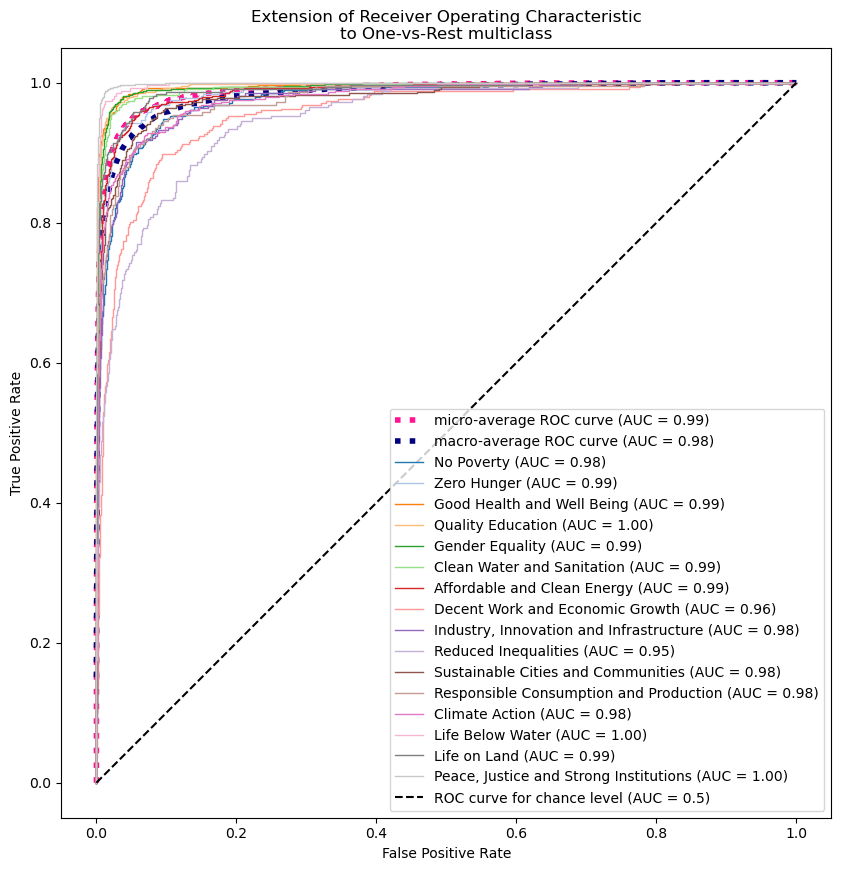

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_names[class_id]}",
        color=color,
        linewidth = 1,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

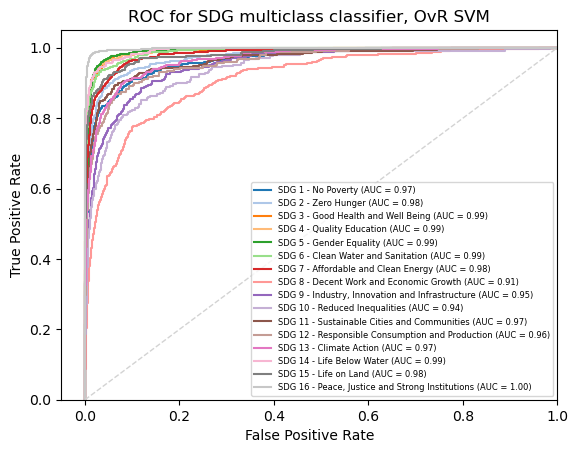

In [16]:
docs = text_df.embedding.tolist()
scaler = preprocessing.MinMaxScaler().fit(docs)
X = scaler.transform(docs)
y = text_df.sdg

label_binarizer = LabelBinarizer().fit(y)
y_onehot = label_binarizer.transform(y)
n_classes = len(label_binarizer.classes_)
class_names = [sdg_names[sdg_names["sdg"] == label_binarizer.classes_[i]].sdg_name.item() \
               for i in range(n_classes)]

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=.33, random_state=0)

ovr_svm_clf = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=0))
ovr_svm_clf.fit(X_train, y_train)
y_score = ovr_svm_clf.decision_function(X_test)

fpr, tpr, roc_auc = dict(), dict(), dict()

for class_id in range(n_classes):
    fpr[class_id], tpr[class_id], _ = metrics.roc_curve(y_test[:, class_id], y_score[:, class_id]) # roc_curve works on binary
    roc_auc[class_id] = metrics.auc(fpr[class_id], tpr[class_id])

for class_id, color in zip(range(n_classes), colors):
    plt.plot(fpr[class_id], tpr[class_id], color=color, lw=1.5,alpha = 1, 
             label='SDG {0} - {1} (AUC = {2:0.2f})'
             ''.format(class_id+1, class_names[class_id], roc_auc[class_id]))
plt.plot([0, 1], [0, 1], '--', lw=1, color="lightgrey")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SDG multiclass classifier, OvR SVM')
plt.legend(loc="lower right", fontsize=6)
plt.show()